# First version of nucleusj in python

TODO:
- open data and metadata (with bioformat? OMERO?)
- visualise it
- auto-crop: 
    - Ostu threshold 
    - Connected component (MorpholibJ)
    - Component of volume > 1um are conserved
    - A bounding box around each connected component --> plus a 20 voxel surrounding
    - Group bounding boxes if they have a IoU > 0.5
    - Generate a Z-projection with the bouding boxes
    - A tabulated file with the list of each nucleus + bboxes coord in a .txt file
- segmentation:
    - do a thresholding Otsu then the modified Ostu?
    - gift-wrapping 
- surface area computation:
    - discrete geometry technique
    - NAMM: can we use ML to find the right transformation from the sphere images?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io
import tifffile as tif
import SimpleITK as sitk
import pandas
import os
import tqdm
from PIL import Image, TiffTags, ImageSequence

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

In [3]:
# paths
img_path = '../data/wide_field.tif'
out_path = '../data/output/'

In [4]:
# open a single image
img = io.imread(img_path)

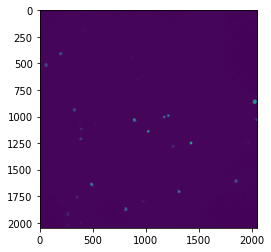

In [5]:
half = len(img)//2
plt.imshow(img[half])

## auto-crop
- Ostu threshold 
- Connected component (MorpholibJ)
- Component of volume > 1um are conserved
- A bounding box around each connected component --> plus a 20 voxel surrounding
- Group bounding boxes if they have a IoU > 0.5
- Generate a Z-projection with the bouding boxes
- A tabulated file with the list of each nucleus + bboxes coord in a .txt file

In [6]:
# ostu threshold
thresh = threshold_otsu(img)
binary = img > thresh

# print("ostu threshold: {}".format(thresh))
# plt.imshow(binary[half])

In [7]:
# connected components
connec = label(binary)
nb_connec = len(np.unique(connec))
print("number of connected components: {}".format(nb_connec))

# plt.imshow(connec[half])

number of connected components: 105


In [8]:
# volume of a connected component
def connec_volume(connec, idx):
    """
    returns the volume in pixel of the connected component of index 'idx' form the image called 'connec'
    """
    return np.sum(connec == idx)

# print the volume of all the connected components in pixel
def connec_volume_all(connec):
    nb_connec = len(np.unique(connec))
    l_connec = []
    for idx, elm in enumerate(np.unique(connec)[1:]): # remove the bg
        l_connec += [connec_volume(connec, elm)]
    return l_connec
l_connec = connec_volume_all(connec)
print(l_connec) # list of all connected component volumes (except of the bg)

[8565, 6242, 8778, 8390, 8166, 21, 5692, 6492, 6646, 7256, 6631, 6167, 24884, 1, 8362, 5479, 7736, 1, 6664, 1, 13, 1, 6049, 5797, 8291, 14, 20, 6727, 6959, 1, 1, 1, 1, 4740, 4291, 1, 6906, 1, 6203, 4243, 1, 2999, 1, 36, 3482, 1, 4, 1, 113, 4366, 2, 1, 3738, 3360, 18351, 6, 1, 1, 1, 2, 2, 1, 1, 1, 4156, 1, 3566, 4408, 1, 1, 2, 1, 1, 1, 2976, 12683, 5696, 1, 1, 57, 1, 1, 1, 2, 4261, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


In [9]:
# remove connected component that are too small
# criteria (arbitrari): below 1000 pixel are removed

connec_clean = np.zeros_like(connec)
for idx, elm in enumerate(l_connec):
    if elm > 1000:
        connec_clean += (connec==(idx+1)).astype(int)*(idx+1)

# l_connec_clean = connec_volume_all(connec_clean)
# print(l_connec_clean)

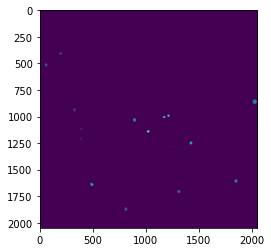

In [10]:
plt.imshow(connec_clean[half])

In [11]:
# crop each connected components by a frame of 20 pixel and save them as tif files
props = regionprops(connec_clean) 

def crop_bbox(img, bbox, margin=20):
    """
    bbox: (ax,ay,az,bx,by,bz)
    """
    # adds margin and assert it is in the right range
    bbox_a = np.array(bbox)[:3]-margin
    bbox_b = np.array(bbox)[3:]+margin
    bbox_ = np.append(bbox_a, bbox_b)
    im_shape = img.shape

    for i in range(2):
        for j in range(3):
            if bbox_[i*3+j] >= img.shape[j]:
                bbox_[i*3+j] = img.shape[j] - 1
            elif bbox_[i*3+j] < 0:
                bbox_[i*3+j] = 0
    ax,ay,az,bx,by,bz = np.array(bbox_)
    return img[ax:bx,ay:by,az:bz], np.array(bbox_)

In [12]:
# io.use_plugin('freeimage')
img_bits = int(2**(2**np.ceil(np.log2(np.ceil(np.log2(np.max(img)))))))


def link_metadata(array, im, out_path):
    """
    link the metadata contained in 'im' (a PIL.Image) to the numpy.array 'array' and save it in 'out_path'
    """
    # convert array to image
    frames = []
#     for i, frame in enumerate(ImageSequence.Iterator(im)):
    for i in range(len(array)):
        
        frame = Image.fromarray(array[i])
#         print({TAGS[key] : frame.tag[key] for key in frame.tag.iterkeys()})
#         print(frame.tag[256])
#         print(type(frame.tag[256]))
#         frame.tag[256] = (array.shape[1],) # image width
#         frame.tag[257] = (array.shape[2],) # image length
        
#         frame = frame.copy()
#         frame.tag[256] = (array.shape[1],) # image width
#         frame.tag[257] = (array.shape[2],) # image length
        frames.append(frame)
        
        
    
    del im.tag[286]
    im.tag[256] = (array.shape[2],) # image width
    im.tag[257] = (array.shape[1],) # image length
#     im.tag[32997] = 0.2
    frames[0].save(out_path, tiffinfo=im.tag, save_all=True, append_images=frames[1:])


i = 0
connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

fname = out_path + str(i) + '.tif'

im = Image.open(img_path)

# meta_dict = {TAGS[key] : im.tag[key] for key in im.tag.iterkeys()}
# print(meta_dict)
link_metadata(connec_crop, im, fname)

    
#     for i in range(len(props)):
#         connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
#         connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

#         fname = out_path + str(i) + '.tif'
    
#         region = im.crop(bbox)
#         region.save(fname)
        
#     io.imsave(fname, connec_crop)
#     bioformats.write_image(fname, connec_crop, bioformats.PT_UINT16)
#     img_itk = sitk.GetImageFromArray(connec_crop)
#     img_itk.SetSpacing(np.array((0.2e-3, 0.1032e-3,0.1032e-3))[::-1])
#     sitk.WriteImage(img_itk, fname)

### tifffile?

In [13]:
# this one solution is very close to what is expected!
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(tag_name, tag_value)

NewSubfileType FILETYPE.PAGE
ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop 

In [14]:
test_path = '../data/output/0.tif'
te = Image.open(test_path)
print(te.tag)

{256: (53,), 257: (69,), 258: (16,), 259: (1,), 262: (1,), 270: ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\n<prop id="ApplicationName" type="string" value="MetaMorph"/

In [15]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)
test_path = '../data/output/0.tif'
te2 = Image.open(test_path)
# print(te2.tag)
for k, v in te1.tag.items():
    if k not in te2.tag.keys() or v not in te2.tag.values():
        print(k, v)
        print(te2.tag[k])
print(te1.tag==te2.tag)

256 (2048,)
(53,)
257 (2048,)
(69,)
273 (8, 8200, 16392, 24584, 32776, 40968, 49160, 57352, 65544, 73736, 81928, 90120, 98312, 106504, 114696, 122888, 131080, 139272, 147464, 155656, 163848, 172040, 180232, 188424, 196616, 204808, 213000, 221192, 229384, 237576, 245768, 253960, 262152, 270344, 278536, 286728, 294920, 303112, 311304, 319496, 327688, 335880, 344072, 352264, 360456, 368648, 376840, 385032, 393224, 401416, 409608, 417800, 425992, 434184, 442376, 450568, 458760, 466952, 475144, 483336, 491528, 499720, 507912, 516104, 524296, 532488, 540680, 548872, 557064, 565256, 573448, 581640, 589832, 598024, 606216, 614408, 622600, 630792, 638984, 647176, 655368, 663560, 671752, 679944, 688136, 696328, 704520, 712712, 720904, 729096, 737288, 745480, 753672, 761864, 770056, 778248, 786440, 794632, 802824, 811016, 819208, 827400, 835592, 843784, 851976, 860168, 868360, 876552, 884744, 892936, 901128, 909320, 917512, 925704, 933896, 942088, 950280, 958472, 966664, 974856, 983048, 991240, 9

In [16]:
# this one solution is very close to what is expected!
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)


test_path = '../data/output/0.tif'
tiw = tif.TiffWriter(test_path, imagej=True)

for frame in tim.pages:
    image = frame.asarray()
    metadata = {}
    for tag in frame.tags:
        metadata[tag.name] = tag.value
    tiw.write(image, contiguous=True, metadata=metadata)
    
tiw.close()

tim.close()

In [17]:
img_path = '../data/wide_field.tif'
# img_path = '../data/output/0.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)


test_path = '../data/output/0.tif'
tiw = tif.TiffWriter(test_path)

for frame in tim.pages:
    image = frame.asarray()
    metadata = {}
    for tag in frame.tags:
        metadata[tag.name] = tag.value
#         print(tag.name)
#         if tag.name == "ImageDescription":
#             print(repr(metadata[tag.name]))
#             metadata[tag.name]=repr(tag.value)
#             val = tag.value.replace('\"','')
#             metadata[tag.name] = tag.value.decode('string_escape')
                
#             print(str(metadata[tag.name]))
    tiw.write(image, contiguous=True, metadata=metadata)

# volume = tif.asarray()
# for i in range()
    
tim.close()
tiw.close()

In [18]:
img_path = '../data/wide_field_copy.tif'
# img_path = '../data/output/0.tif'
tim = tif.TiffFile(img_path, mode='r+b')
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        tag.overwrite("")
        print(tag_name, tag_value)


# test_path = '../data/output/0.tif'
# tiw = tif.TiffFile(test_path, mode='r+b')
# for page in tiw.pages:
#     for tag in page.tags:
#         tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)

# for i, frame in enumerate(tiw.pages):
#     for tag in tim.pages[i].tags:
#         _ = frame.tags[tag.name].overwrite(tag.value)

# # volume = tif.asarray()
# # for i in range()
    

# tiw.close()
tim.close()

FileNotFoundError: [Errno 2] No such file or directory: '/home/mougeotg/all/codes/python/nj2_python/data/wide_field_copy.tif'

In [ ]:
img_path = '../data/wide_field.tif'

tim = tif.TiffFile(img_path)

output = '../data/output/0.tif'

tiw = tif.TiffWriter(output)

tiw.write(tim)

### PIL?

In [ ]:
im.tag[256]

In [ ]:
## with the code below I keep the x and y informations but not the z one... 
im = Image.open(img_path)
tags=im.tag
frames = []
for i, frame in enumerate(ImageSequence.Iterator(im)):
    frame = frame.copy()
    frames.append(frame)
frames[0].save('../data/rot.tif', tiffinfo=im.tag, save_all=True, append_images=frames[1:])

In [ ]:
from PIL import Image, ImageSequence
path = 'sample.tiff'

im = Image.open(path)
frames = []
for i, frame in enumerate(ImageSequence.Iterator(im)):
    frame = frame.copy()

    # Perform an operation, for example, rotate the second frame
    if i == 1:
        frame = frame.rotate(5)

    frames.append(frame)
del im.tag[286]
frames[0].save('../data/rot.tif', tiffinfo=im.tag, save_all=True, append_images=frames[1:])

### PIL and tifffile

In [19]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
tags = []
for i, frame in enumerate(ImageSequence.Iterator(te1)):
    tags += [frame.tag]

In [20]:
tif.TIFF.DATA_DTYPES

{'B': 1,
 's': 2,
 'H': 3,
 'I': 4,
 '2I': 5,
 'b': 6,
 'h': 8,
 'i': 9,
 '2i': 10,
 'f': 11,
 'd': 12,
 'Q': 16,
 'q': 17}

In [21]:
print(tif.TIFF.TAGS[257])

ImageLength


In [22]:
list(tif.TIFF.DATATYPES)

[<DATATYPES.BYTE: 1>,
 <DATATYPES.ASCII: 2>,
 <DATATYPES.SHORT: 3>,
 <DATATYPES.LONG: 4>,
 <DATATYPES.RATIONAL: 5>,
 <DATATYPES.SBYTE: 6>,
 <DATATYPES.UNDEFINED: 7>,
 <DATATYPES.SSHORT: 8>,
 <DATATYPES.SLONG: 9>,
 <DATATYPES.SRATIONAL: 10>,
 <DATATYPES.FLOAT: 11>,
 <DATATYPES.DOUBLE: 12>,
 <DATATYPES.IFD: 13>,
 <DATATYPES.UNICODE: 14>,
 <DATATYPES.COMPLEX: 15>,
 <DATATYPES.LONG8: 16>,
 <DATATYPES.SLONG8: 17>,
 <DATATYPES.IFD8: 18>]

In [23]:
print(tags[0])

{256: (2048,), 257: (2048,), 258: (16,), 259: (1,), 262: (1,), 270: ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\n<prop id="ApplicationName" type="string" value="MetaMor

In [24]:
tif.TIFF.DATATYPES.LONG

<DATATYPES.LONG: 4>

In [25]:
reformat = []
for i in range(len(tags)):
    tmp = []
    for k, v in tags[i].items():
        if type(v[0])==int and len(v)==1:
            ty = tif.TIFF.DATATYPES.LONG 
            tmp += [(k,ty,1,v[0],True)]
        else:
            ty = tif.TIFF.DATATYPES.BYTE
            tmp += [(k,ty,len(v),v,True)]
    reformat += [tmp]

In [26]:
print(*reformat[0])

(256, <DATATYPES.LONG: 4>, 1, 2048, True) (257, <DATATYPES.LONG: 4>, 1, 2048, True) (258, <DATATYPES.LONG: 4>, 1, 16, True) (259, <DATATYPES.LONG: 4>, 1, 1, True) (262, <DATATYPES.LONG: 4>, 1, 1, True) (270, <DATATYPES.BYTE: 1>, 1, ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electr

In [ ]:
PIL.ExifTags.TAGS

In [ ]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)

test_path = '../data/output/0.ome.tif'
tiw = tif.TiffWriter(test_path, imagej=True)

for i, frame in enumerate(ImageSequence.Iterator(te1)):
    image = np.array(frame.copy())
#     metadata = {}
#     for tag in frame.tags:
#         metadata[tag.name] = tag.value
    print(i)
    tiw.write(image, contiguous=True, extratags=reformat[i])
    
tiw.close()

### retry with tifffile

In [27]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
list_meta_pil = []
for k, v in te1.tag.items():
    desc = tif.TIFF.TAGS[k]
    print(desc, v)
    list_meta_pil += [desc]

ImageWidth (2048,)
ImageLength (2048,)
BitsPerSample (16,)
Compression (1,)
PhotometricInterpretation (1,)
ImageDescription ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\

In [28]:
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)


for page in tim.pages:
    count = 0
    list_meta_tif = []
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(count, tag_name, tag_value)
        count += 1
        list_meta_tif += [tag_name]
    break

0 NewSubfileType FILETYPE.PAGE
1 ImageWidth 2048
2 ImageLength 2048
3 BitsPerSample 16
4 Compression COMPRESSION.NONE
5 PhotometricInterpretation PHOTOMETRIC.MINISBLACK
6 ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&

In [29]:
list_meta_pil

['ImageWidth',
 'ImageLength',
 'BitsPerSample',
 'Compression',
 'PhotometricInterpretation',
 'ImageDescription',
 'StripOffsets',
 'Orientation',
 'Software',
 'DateTime',
 'SamplesPerPixel',
 'RowsPerStrip',
 'StripByteCounts',
 'NewSubfileType']

In [30]:
list_meta_tif

['NewSubfileType',
 'ImageWidth',
 'ImageLength',
 'BitsPerSample',
 'Compression',
 'PhotometricInterpretation',
 'ImageDescription',
 'StripOffsets',
 'Orientation',
 'SamplesPerPixel',
 'RowsPerStrip',
 'StripByteCounts',
 'Software',
 'DateTime']

In [31]:
for e in list_meta_pil:
    if e not in list_meta_tif:
        print(e)

In [ ]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)

test_path = '../data/output/0.ome.tif'

img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)


for page in tim.pages:
    count = 0
    list_meta_tif = []
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(count, tag_name, tag_value)
        count += 1
        list_meta_tif += [tag_name]
    break

### bioformat?

In [ ]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

In [ ]:
t = bioformats.Image()

In [ ]:
j_im = bioformats.ImageReader(img_path)
bioformats.write_image()

In [ ]:
def props(cls):   
    return [i for i in cls.__dict__.keys() if i[:1] != '_']

properties = props(bioformats.ImageReader)
print(properties)